In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
# data_IO_C_all.to_csv('data_IO_C_all.csv',index=False)
data_IO_C_all=pd.read_csv('data_IO_C_all.csv')
data_IO_C_all.head()

,date,IF_close,code,strike,IOIF_delta_price,exp_day,IO_close
0,2020-01-20,4194.8,IO2002-C-3550,3550,-644.8,32,643.8
1,2020-01-20,4194.8,IO2002-C-3600,3600,-594.8,32,594.0
2,2020-01-20,4194.8,IO2002-C-3650,3650,-544.8,32,553.2
3,2020-01-20,4194.8,IO2002-C-3700,3700,-494.8,32,506.4
4,2020-01-20,4194.8,IO2002-C-3750,3750,-444.8,32,457.0


# 用LSTM来拟合CALL_STL_PRICE和PUT_STL_PRICE

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

def LoadData(df, sequence_length):
    features = df[['IF_close', 'IOIF_delta_price', 'exp_day']].values
    labels = df['IO_close'].values

    # 数据标准化
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # 创建序列
    X = create_sequences(features, sequence_length)
    y = labels[sequence_length-1:]

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)
    
    # 转换为PyTorch张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # DataLoader
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    Batch_size = 64
    
    train_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=Batch_size)
    test_loader = DataLoader(test_data, batch_size=Batch_size)
    
    return train_loader, val_loader, test_loader

In [4]:
import torch.nn as nn

# 定义LSTM模型
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)      
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        device = x.device
        # 初始化
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)    

        out, _ = self.lstm(x, (h0, c0))   
        out = out[:, -1, :]# 取LSTM输出的最后一个时间步
        out = self.fc(out)
        return out

In [5]:
# mlp_resnet.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLPBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ResidualMLP, self).__init__()
        self.mlp = MLPBlock(input_dim, hidden_dim, output_dim)
        self.shortcut = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.mlp(x)
        x += identity
        return x


# 下一步我们将定义整个 ResNet 类，它将包含多个这样的残差 MLP 块。请输入 "next" 或 "continue" 来进行下一步。😄
class MLPResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks):
        super(MLPResNet, self).__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.res_blocks = nn.ModuleList([ResidualMLP(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_blocks)])
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.input_fc(x))
        for block in self.res_blocks:
            x = block(x)
        x = self.output_fc(x)
        x = torch.squeeze(x, -1)
        return x

In [6]:
#定义参数的CLASS
class Args():
    def __init__(self):
        self.lr=0.01
        self.num_epochs=150
        self.best_val_loss=float('inf')
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using {self.device}')
        self.criterion=nn.MSELoss()
        self.optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
        #self.scheduler=ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-6, verbose=True)

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def train(model, train_loader, val_loader, args):
    print(f'Training on {args.device}...')
    model.to(args.device)
    criterion = args.criterion
    optimizer = args.optimizer
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-7, verbose=True)

    num_epochs = args.num_epochs
    best_val_loss = args.best_val_loss

    early_stop_patience = 10  # 设置早停
    epochs_no_improve = 0 

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(args.device), targets.to(args.device)
                outputs = model(inputs)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, targets)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 更新 scheduler
        scheduler.step(avg_val_loss)

        # 保存最好的模型，并检查早停条件
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # 检查是否达到早停条件
        if epochs_no_improve == early_stop_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break
    print("模型训练完成！")
    return model

LSTM模型评估

LSTMRegressor(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Using cuda
Training on cuda...
Epoch [1/150], Training Loss: 182702.4064, Validation Loss: 57833.2174
Epoch [2/150], Training Loss: 146767.9927, Validation Loss: 60795.9203
Epoch [3/150], Training Loss: 139238.4722, Validation Loss: 66817.1008
Epoch [4/150], Training Loss: 138364.3848, Validation Loss: 68991.4296
Epoch [5/150], Training Loss: 138456.4201, Validation Loss: 69369.3653
Epoch [6/150], Training Loss: 82416.4031, Validation Loss: 6693.8751
Epoch [7/150], Training Loss: 48468.8301, Validation Loss: 2061.0177
Epoch [8/150], Training Loss: 34434.2421, Validation Loss: 708.1272
Epoch [9/150], Training Loss: 25909.8555, Validation Loss: 291.3190
Epoch [10/150], Training Loss: 20049.3165, Validation Loss: 129.7757
Epoch [11/150], Training Loss: 15871.0249, Validation Loss: 212.5452
Epoch [12/150], Training Loss: 12634.7719, Validation Loss: 160.5687
Epoc

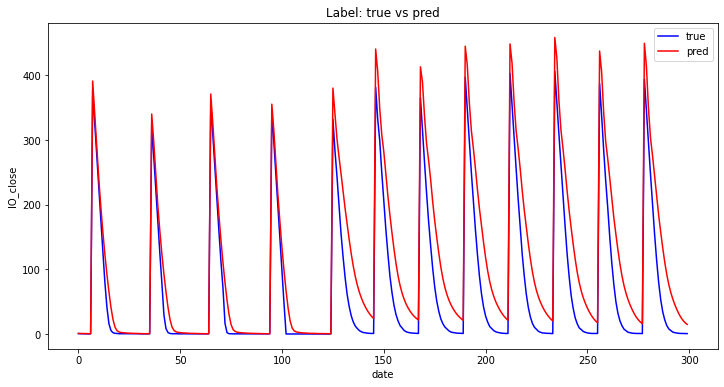

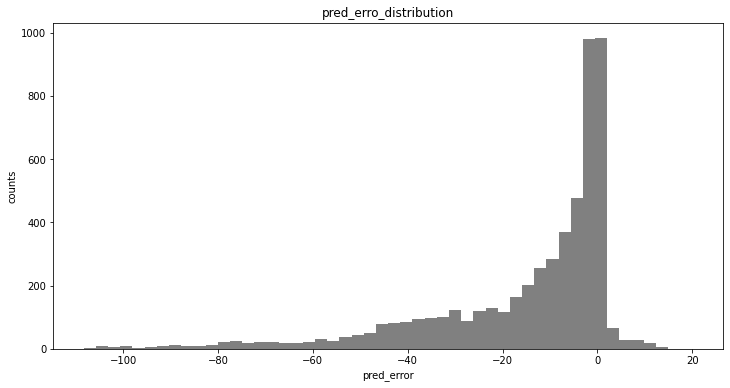


展示部分test_set上的拟合效果
       y_test  y_test_pred
0  658.400024   660.093201
1  608.599976   615.742554
2  558.799988   565.935974
3  509.600006   515.039734
4  462.600006   465.684265


测试集平均损失: 648.2236





In [8]:
# 模型评估
def TEST(test_loader,args,model):
    print(f'Testing on {args.device}...')
    model.to(args.device)
    criterion=args.criterion
    model.eval()  
    total_loss = 0.0
    
    with torch.no_grad():  # 在评估阶段不计算梯度
        for inputs, targets in test_loader:
            # 将数据移动到GPU上
            inputs,targets = inputs.to(args.device),targets.to(args.device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item()
            
    #绘图和计算误差
    model.eval()  
    predictions = []
    actuals = []
    for inputs, targets in test_loader:
        inputs,targets = inputs.to(args.device),targets.to(args.device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(targets.tolist())
        
    # 转换为numpy数组以便绘图
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # 可视化1: 真实值与预测值的对比
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[-300:], label='true', color='blue')
    plt.plot(predictions[-300:], label='pred', color='red')
    plt.title('Label: true vs pred')
    plt.xlabel('date')
    plt.ylabel('IO_close')
    plt.legend()
    plt.show()
    
    # 可视化2: 预测误差的分布
    errors = actuals - predictions
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=50, color='gray')
    plt.title('pred_erro_distribution')
    plt.xlabel('pred_error')
    plt.ylabel('counts')
    plt.show()
    
    # 将测试集的实际值和预测值转换为numpy数组（如果它们还不是的话）
    actuals_np = np.array(actuals)  
    predictions_np = np.array(predictions)  
    results_df = pd.DataFrame({'y_test': actuals_np,'y_test_pred': predictions_np})
    # 显示DataFrame的前几行
    print("\n展示部分test_set上的拟合效果")
    print(results_df.head())
    print('\n')
    print(f'测试集平均损失: {total_loss/len(test_loader):.4f}\n')
    return results_df
#模型参数

input_size = 3  # 由于有三个特征
hidden_size = 64  # 隐藏层大小
num_layers = 2  # LSTM层数
model = LSTMRegressor(input_size, hidden_size, num_layers=num_layers)
print(model)
len_seq = 30
train_loader,val_loader,test_loader=LoadData(data_IO_C_all,len_seq)
args=Args()
model=train(model,train_loader,val_loader,args)
TEST(test_loader,args,model)
print('\n')

In [9]:
# mlp_resnet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ResidualMLP, self).__init__()
        self.mlp = MLPBlock(input_dim, hidden_dim, output_dim)
        self.shortcut = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.mlp(x)
        x += identity
        return x
    
class MLPResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks):
        super(MLPResNet, self).__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.res_blocks = nn.ModuleList([ResidualMLP(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_blocks)])
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, len_seq, _ = x.shape
        outputs = []

        for t in range(len_seq):
            xt = x[:, t, :]
            xt = F.relu(self.input_fc(xt))
            for block in self.res_blocks:
                xt = block(xt)
            xt = self.output_fc(xt)
            outputs.append(xt)

        # Aggregate outputs
        outputs = torch.stack(outputs, dim=1)  # [batch_size, len_seq, output_dim]
        outputs = torch.mean(outputs, dim=1)  # [batch_size, output_dim]

        return outputs
# 下一步我们将定义整个 ResNet 类，它将包含多个这样的残差 MLP 块。请输入 "next" 或 "continue" 来进行下一步。😄

MLPResNet(
  (input_fc): Linear(in_features=3, out_features=64, bias=True)
  (res_blocks): ModuleList(
    (0): ResidualMLP(
      (mlp): MLPBlock(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
      (shortcut): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): ResidualMLP(
      (mlp): MLPBlock(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
      (shortcut): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): ResidualMLP(
      (mlp): MLPBlock(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
      (shortcut): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): ResidualMLP(
      (mlp): MLPBlock(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
      

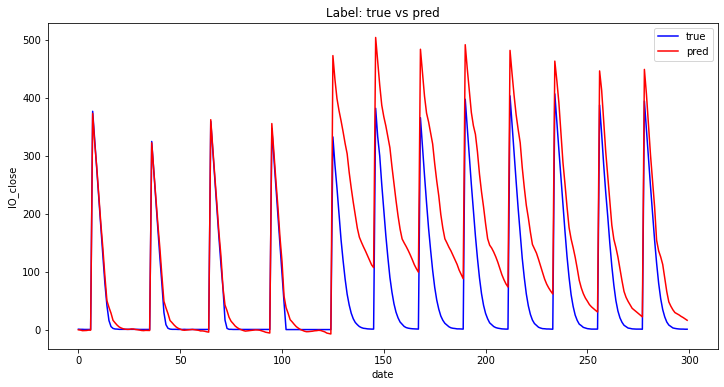

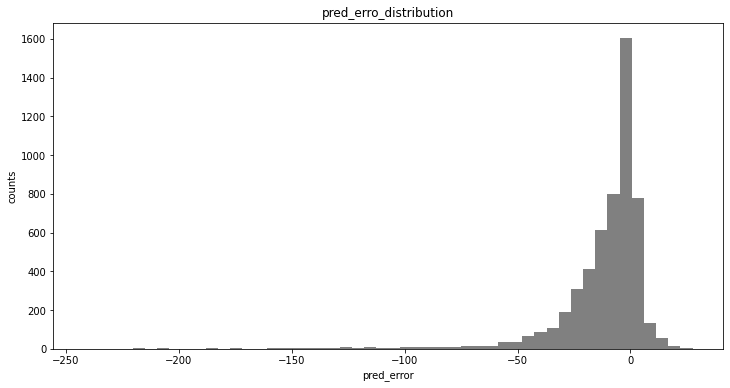


展示部分test_set上的拟合效果
        y_test  y_test_pred
0     1.200000     3.304350
1     1.000000     2.915198
2  1007.599976  1019.340820
3   907.799988   918.450562
4   808.000000   816.584961


测试集平均损失: 769.1202



,y_test,y_test_pred
0,1.200000,3.304350
1,1.000000,2.915198
2,1007.599976,1019.340820
3,907.799988,918.450562
4,808.000000,816.584961
...,...,...
5428,1.000000,25.291430
5429,0.800000,22.785372
5430,0.800000,20.792238
5431,0.600000,18.427671


In [10]:
model = MLPResNet(input_dim=3, hidden_dim=64, output_dim=1, num_blocks=5)  # num_blocks=2 表示有两个残差块,实际的层数为 num_blocks + 1
print(model)
train_loader,val_loader,test_loader=LoadData(data_IO_C_all,1)
args=Args()
args.lr = 0.0001
args.num_epochs= 50
model=train(model,train_loader,val_loader,args)
TEST(test_loader,args,model)